In [3]:
#also ref: https://www.tensorflow.org/tutorials/representation/word2vec

In [4]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE = 20
#Dimension of the embedding vector. Two too small to get
#any meaningful embeddings, but let's make it 2 for simple visualization
EMBEDDING_SIZE = 2
NUM_SAMPLED = 15 #Number of negative examples to sample

#Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

#sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
print("Word count", count[:5])

#Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

#Make indexed word data
data = [dic[word] for word in words]
print("Sample data", data[:10], [rdic[t] for t in data[:10]])


#Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...

cbow_pairs = []
for i in range(1, len(data) - 1):
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]])
print("Context pairs", cbow_pairs[:10])

#Let's make skip-gram pairs
#(quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = []

for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print("Skip-gram pairs", skip_gram_pairs[:10])

def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data = []
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), 
                         size, 
                         replace=False)#without repetition
    
    for i in r:
        x_data.append(skip_gram_pairs[i][0])
        y_data.append(skip_gram_pairs[i][1])
    return x_data, y_data
        
print("Batches (x,y)", generate_batch (3))


Word count [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]
Sample data [5, 9, 10, 11, 12, 13, 5, 14, 15, 16] ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']
Context pairs [[[5, 10], 9], [[9, 11], 10], [[10, 12], 11], [[11, 13], 12], [[12, 5], 13], [[13, 14], 5], [[5, 15], 14], [[14, 16], 15], [[15, 4], 16], [[16, 0], 4]]
Skip-gram pairs [[9, 5], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [13, 12], [13, 5]]
Batches (x,y) ([19, 1, 1], [0, 3, 2])


In [5]:
#Input data
train_inputs = tf.placeholder(tf.int32, shape = [BATCH_SIZE])
#need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape = [BATCH_SIZE, 1])
#Ops and variables to th CPU because of missing GPU implementation

#What is embedding_lookup
#Example form https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do#41922877

# Yes, the purpose of tf.nn.embedding_lookup() function is to perform a lookup in the embedding matrix and return the embeddings (or in simple terms the vector representation) of words.

# A simple embedding matrix (of shape: vocabulary_size x embedding_dimension) would look like below. (i.e. each word will be represented by a vector of numbers; hence the name word2vec)

# Embedding Matrix

# the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862
# like 0.36808 0.20834 -0.22319 0.046283 0.20098 0.27515 -0.77127 -0.76804
# between 0.7503 0.71623 -0.27033 0.20059 -0.17008 0.68568 -0.061672 -0.054638
# did 0.042523 -0.21172 0.044739 -0.19248 0.26224 0.0043991 -0.88195 0.55184
# just 0.17698 0.065221 0.28548 -0.4243 0.7499 -0.14892 -0.66786 0.11788
# national -1.1105 0.94945 -0.17078 0.93037 -0.2477 -0.70633 -0.8649 -0.56118
# day 0.11626 0.53897 -0.39514 -0.26027 0.57706 -0.79198 -0.88374 0.30119
# country -0.13531 0.15485 -0.07309 0.034013 -0.054457 -0.20541 -0.60086 -0.22407
# under 0.13721 -0.295 -0.05916 -0.59235 0.02301 0.21884 -0.34254 -0.70213
# such 0.61012 0.33512 -0.53499 0.36139 -0.39866 0.70627 -0.18699 -0.77246
# second -0.29809 0.28069 0.087102 0.54455 0.70003 0.44778 -0.72565 0.62309 
# I split the above embedding matrix and loaded only the words in vocab which will be our vocabulary and the corresponding vectors in emb array.

# vocab = ['the','like','between','did','just','national','day','country','under','such','second']

# emb = np.array([[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862],
#    [0.36808, 0.20834, -0.22319, 0.046283, 0.20098, 0.27515, -0.77127, -0.76804],
#    [0.7503, 0.71623, -0.27033, 0.20059, -0.17008, 0.68568, -0.061672, -0.054638],
#    [0.042523, -0.21172, 0.044739, -0.19248, 0.26224, 0.0043991, -0.88195, 0.55184],
#    [0.17698, 0.065221, 0.28548, -0.4243, 0.7499, -0.14892, -0.66786, 0.11788],
#    [-1.1105, 0.94945, -0.17078, 0.93037, -0.2477, -0.70633, -0.8649, -0.56118],
#    [0.11626, 0.53897, -0.39514, -0.26027, 0.57706, -0.79198, -0.88374, 0.30119],
#    [-0.13531, 0.15485, -0.07309, 0.034013, -0.054457, -0.20541, -0.60086, -0.22407],
#    [ 0.13721, -0.295, -0.05916, -0.59235, 0.02301, 0.21884, -0.34254, -0.70213],
#    [ 0.61012, 0.33512, -0.53499, 0.36139, -0.39866, 0.70627, -0.18699, -0.77246 ],
#    [ -0.29809, 0.28069, 0.087102, 0.54455, 0.70003, 0.44778, -0.72565, 0.62309 ]])


# emb.shape
# # (11, 8)



# In [54]: from collections import OrderedDict

# # embedding as TF tensor (for now constant; could be tf.Variable() during training)
# In [55]: tf_embedding = tf.constant(emb, dtype=tf.float32)

# # input for which we need the embedding
# In [56]: input_str = "like the country"

# # build index based on our `vocabulary`
# In [57]: word_to_idx = OrderedDict({w:vocab.index(w) for w in input_str.split() if w in vocab})

# # lookup in embedding matrix & return the vectors for the input words
# In [58]: tf.nn.embedding_lookup(tf_embedding, list(word_to_idx.values())).eval()
# Out[58]: 
# array([[ 0.36807999,  0.20834   , -0.22318999,  0.046283  ,  0.20097999,
#          0.27515   , -0.77126998, -0.76804   ],
#        [ 0.41800001,  0.24968   , -0.41242   ,  0.1217    ,  0.34527001,
#         -0.044457  , -0.49687999, -0.17862   ],
#        [-0.13530999,  0.15485001, -0.07309   ,  0.034013  , -0.054457  ,
#         -0.20541   , -0.60086   , -0.22407   ]], dtype=float32)


with tf.device("/cpu:0"):
    #Look up embeddings for inputs
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, EMBEDDING_SIZE], -1.0, 1.0 ))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) #lookup table
    
#Construct the variables for the NCE loss
nce_weights = tf.Variable(
        tf.random_uniform([voc_size, EMBEDDING_SIZE], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

#Compute the average NCE loss for the batch.
#This does the magic:
# tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
#It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, 
                                     nce_biases, 
                                     train_labels, 
                                     embed, 
                                     NUM_SAMPLED, 
                                     voc_size))
#Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)


#Why is nce?
#https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss

#Taken from this post:https://stats.stackexchange.com/a/245452/154812

# The issue

# There are some issues with learning the word vectors using an 
#"standard" neural network. 
#In this way, the word vectors are learned while the network 
#learns to predict the next word given a window of words 
#(the input of the network).

# Predicting the next word is like predicting the class. 
#That is, such a network is just a "standard" multinomial (multi-class) 
#classifier. And this network must have as many output neurons 
#as classes there are. When classes are actual words, 
#the number of neurons is, well, huge.

# A "standard" neural network is usually trained with a 
#cross-entropy cost function which requires the values of the 
#output neurons to represent probabilities - which means that the 
#output "scores" computed by the network for each class have to be 
#normalized, converted into actual probabilities for each class. 
#This normalization step is achieved by means of the softmax function. 
#Softmax is very costly when applied to a huge output layer.

# The (a) solution

# In order to deal with this issue, that is, 
#the expensive computation of the softmax, Word2Vec uses a technique 
#called noise-contrastive estimation. This technique was introduced by [A] (reformulated by [B]) then used in [C], [D], [E] to learn word embeddings from unlabelled natural language text.

# The basic idea is to convert a multinomial classification problem 
#(as it is the problem of predicting the next word) to a binary 
#classification problem. That is, instead of using softmax to estimate 
#a true probability distribution of the output word, a binary logistic 
#regression (binary classification) is used instead.

# For each training sample, the enhanced (optimized) classifier 
#is fed a true pair (a center word and another word that appears 
#in its context) and a number of kk randomly 
#corrupted pairs (consisting of the center word and a randomly 
#chosen word from the vocabulary). By learning to distinguish the 
#true pairs from corrupted ones, the classifier will ultimately 
#learn the word vectors.

# This is important: instead of predicting the next word 
#(the "standard" training technique), the optimized classifier 
#simply predicts whether a pair of words is good or bad.

# Word2Vec slightly customizes the process and calls it negative 
#sampling. In Word2Vec, the words for the negative samples 
#(used for the corrupted pairs) are drawn from a specially designed 
#distribution, which favours less frequent words to be drawn more often.



Loss at  0 15.181221
Loss at  10 14.946536
Loss at  20 8.069888
Loss at  30 4.529176
Loss at  40 3.6995373
Loss at  50 3.739333
Loss at  60 3.5040703
Loss at  70 3.262338
Loss at  80 3.4601192
Loss at  90 3.1237645
Loss at  100 3.3771636
Loss at  110 3.3121133
Loss at  120 3.22277
Loss at  130 2.7870417
Loss at  140 3.3953514
Loss at  150 3.3276677
Loss at  160 2.921762
Loss at  170 3.048331
Loss at  180 3.2275734
Loss at  190 3.0007453
Loss at  200 3.4323974
Loss at  210 3.1353002
Loss at  220 3.0935943
Loss at  230 3.1800663
Loss at  240 3.1228893
Loss at  250 3.0672822
Loss at  260 3.2389615
Loss at  270 3.3518054
Loss at  280 2.8763998
Loss at  290 3.3860672
Loss at  300 2.894986
Loss at  310 2.8796551
Loss at  320 3.0470464
Loss at  330 3.2442498
Loss at  340 3.152887
Loss at  350 2.8767428
Loss at  360 3.1467235
Loss at  370 3.0152001
Loss at  380 3.2283607
Loss at  390 3.1000564
Loss at  400 3.2323012
Loss at  410 2.7987564
Loss at  420 2.9202645
Loss at  430 2.946809
Loss at  4

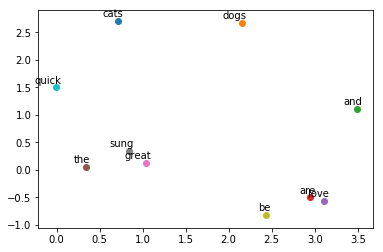

In [6]:
#Launch the graph in a session

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for step in range(1000):
        batch_inputs, batch_labels = generate_batch(BATCH_SIZE)
        batch_labels = np.array(batch_labels)
        batch_labels = np.expand_dims(batch_labels, axis = 1)
        _, loss_val = sess.run([train_op, loss],
                            feed_dict = {train_inputs:batch_inputs,
                                         train_labels:batch_labels})
        if step % 10 == 0:
            print("Loss at ", step, loss_val) 
    #Final embeddings are ready for you to use. 
    #Need to normalize for practical use
    trained_emb = embeddings.eval()
    
#Show word2vec if dim is 2
if trained_emb.shape[1] == 2:
    labels = rdic[:10] #Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_emb[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2),
                    textcoords = "offset points", ha = "right", va = "bottom")
    plt.show()